# 🎈 SLDT를 활용한 물류센터 설립 위치 선정 🎈 

사용한 KPI : 주별 물류 처리 소요 시간 SLDT(State Logistics Duration Time)
  
SLDT = {∑(배송완료 - 물류센터 도착 시점) / 주문 건수} * 일
  
  이를 주별로 계산한 값을 SLDT로 설정하였습니다.
  그리고 이를 바탕으로 로컬 물류 센터을 설립할만한 입지를 선정합니다.
  
코드 분석은  
1.데이터 전처리 - 2.데이터 병합 - 3.탐색적 데이터 분석  
순서로 진행됩니다.

![KPI 연상 이미지](Forjn.png)

# 1. 데이터 전처리
각 파일을 병합하여 사용할 것이기 때문에, 병합 전에 각 파일의 정보를 잘 활용할 수 있도록 새로운 컬럼에 정보들을 저장할 것입니다.   

먼저 기본 라이브러리를 불러옵니다

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

8개의 파일을 불러옵니다.   
그리고 각 데이터의 길이를 확인해서 정보가 얼마나 존재하는지 알아봅니다.

In [2]:
customers = pd.read_csv("./customers.csv")
locations = pd.read_csv("./locations.csv")
order_items = pd.read_csv("./order_items.csv")
orders = pd.read_csv("./orders.csv")
payments = pd.read_csv("./payments.csv")
products = pd.read_csv("./products.csv")
reviews = pd.read_csv("./reviews.csv")
sellers = pd.read_csv("./sellers.csv")

In [3]:
print(f"customers 길이 : {len(customers)}")
print(f"locations 길이 : {len(locations)}")
print(f"order_items 길이 : {len(order_items)}") 
print(f"orders 길이 : {len(orders)}")
print(f"payments 길이 : {len(payments)}") 
print(f"products 길이 : {len(products)}")
print(f"reviews 길이 : {len(reviews)}")
print(f"sellers 길이 : {len(sellers)}")

customers 길이 : 87955
locations 길이 : 1000163
order_items 길이 : 100557
orders 길이 : 87955
payments 길이 : 91971
products 길이 : 29471
reviews 길이 : 87873
sellers 길이 : 2763


🎈 위의 파일 중에서 customers.csv 파일에선 state에 해당하는 데이터들을 브라질에서 사용하는 언어(포르투갈어)로 매핑하여 새로운 열에 저장합니다.

In [4]:
state_name_mapping = {
    'palmas': 'Nova York','sao paulo': 'Los Angeles','aracaju': 'Chicago', 'Miami': 'Miami',
    'SP':'São Paulo','SC':'Santa Catarina', 'MG':'Minas Gerais', 'PR':'Paraná', 'RJ':'Rio de Janeiro', 
    'RS':'Rio Grande do Sul', 'PA':'Pará', 'GO':'Goiás', 'ES':'Espírito Santo', 'BA':'Bahia', 
    'MS':'Mato Grosso do Sul','CE':'Ceará', 'DF':'Distrito Federal', 'RN':'Rio Grande do Norte', 
    'PE':'Pernambuco', 'MT':'Mato Grosso', 'MA':'Maranhão', 'AM':'Amazonas', 'AP':'Amapá', 
    'AL':'Alagoas', 'RO':'Rondônia', 'PB':'Paraíba','TO':'Tocantins', 'PI':'Piauí', 
    'AC':'Acre', 'SE':'Sergipe', 'RR':'Roraima'
}

In [5]:
customers['Customer_state_Brazilian'] = customers['Customer_state'].map(state_name_mapping)
customers.head(2)

,Customer_id,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Customer_state_Brazilian
0,CUSTOMER_00000,CUSTOMER_Unique_00000,14409,franca,SP,São Paulo
1,CUSTOMER_00001,CUSTOMER_Unique_00001,9790,sao bernardo do campo,SP,São Paulo


🎈 이렇게 컬럼을 추가한 데이터프레임을 새로운 파일로 저장한 뒤에, 이것을 customers로 불러옵니다.

In [6]:
customers.to_csv("customerscopy.csv")

In [7]:
customers = pd.read_csv("./customerscopy.csv", index_col=0)

🎈 위의 파일 중에서 orders.csv(주문과 관련된 정보) 파일은 가공을 추가해서 정보를 더 얻고자 합니다.

In [8]:
orders.head(2)

,Order_id,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date
0,ORDER_00000,CUSTOMER_62232,delivered,2018-10-02 10:56:33,2018-10-04 19:55:00,2018-10-10 21:25:13,2018-10-18
1,ORDER_00001,CUSTOMER_54059,delivered,2018-11-18 19:28:06,2018-11-22 13:39:59,2018-12-02 00:28:42,2018-12-15


배송 날짜를 일괄적으로 처리하기 위하여 날짜/시간 형식으로 변환합니다.<br>
Pandas의 to_datetime함수를 가져옵니다.

In [9]:
orders['Order_purchase_timestamp'] = pd.to_datetime(orders['Order_purchase_timestamp'])
orders['Order_delivered_customer_date'] = pd.to_datetime(orders['Order_delivered_customer_date'])
orders['Order_delivered_carrier_date'] = pd.to_datetime(orders['Order_delivered_carrier_date'])
orders['Order_estimated_delivery_date'] = pd.to_datetime(orders['Order_estimated_delivery_date'])

🎈 월 정보와 시간대별 정보를 새로운 컬럼으로 저장합니다.

In [10]:
orders['Purchase_Month'] = orders['Order_purchase_timestamp'].dt.month
orders['Purchase_Hour'] = orders['Order_purchase_timestamp'].dt.hour

In [11]:
orders.head(3)

,Order_id,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Purchase_Month,Purchase_Hour
0,ORDER_00000,CUSTOMER_62232,delivered,2018-10-02 10:56:33,2018-10-04 19:55:00,2018-10-10 21:25:13,2018-10-18,10,10
1,ORDER_00001,CUSTOMER_54059,delivered,2018-11-18 19:28:06,2018-11-22 13:39:59,2018-12-02 00:28:42,2018-12-15,11,19
2,ORDER_00002,CUSTOMER_59535,delivered,2019-02-13 21:18:39,2019-02-14 19:46:34,2019-02-16 18:17:02,2019-02-26,2,21


🎈 구매 날짜와 실제 배송 날짜 사이의 관계를 알아보기 위해 그 시간의 차이를 계산하여 새로운 열에 저장합니다.

In [12]:
orders['Delivery_duration'] = orders['Order_delivered_customer_date'] - orders['Order_purchase_timestamp']
orders.head(2)

,Order_id,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Purchase_Month,Purchase_Hour,Delivery_duration
0,ORDER_00000,CUSTOMER_62232,delivered,2018-10-02 10:56:33,2018-10-04 19:55:00,2018-10-10 21:25:13,2018-10-18,10,10,8 days 10:28:40
1,ORDER_00001,CUSTOMER_54059,delivered,2018-11-18 19:28:06,2018-11-22 13:39:59,2018-12-02 00:28:42,2018-12-15,11,19,13 days 05:00:36


구매 날짜와 실제 배송 날짜의 차이를 다양한 지표로 확인합니다.
  

🎈 기대 배송 날짜와 실제 배송 날짜 사이의 관계를 알아봅니다. 마찬가지로 그 시간의 차이를 새로운 열에 저장합니다.  
기대 배송 날짜보다 실제 배송 날짜가 늦은 경우엔 "delayed"라고 표시하고,  
기대 배송 날짜보다 실제 배송 날짜가 빠른 경우엔 "On-time"으로 표시하는 함수를 만듭니다.

In [13]:
orders['Delivery_status'] = orders.apply(lambda x: 'delayed' if x['Order_estimated_delivery_date'] > x['Order_delivered_customer_date'] else 'on_time', axis=1)
orders.head(2)

,Order_id,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Purchase_Month,Purchase_Hour,Delivery_duration,Delivery_status
0,ORDER_00000,CUSTOMER_62232,delivered,2018-10-02 10:56:33,2018-10-04 19:55:00,2018-10-10 21:25:13,2018-10-18,10,10,8 days 10:28:40,delayed
1,ORDER_00001,CUSTOMER_54059,delivered,2018-11-18 19:28:06,2018-11-22 13:39:59,2018-12-02 00:28:42,2018-12-15,11,19,13 days 05:00:36,delayed


🎈 구매 날짜와 물류 처리 시간 사이의 관계도 알아봅니다. 마찬가지로 그 시간의 차이를 새로운 열에 저장합니다.

In [14]:
orders['Order_to_carrier'] = orders['Order_delivered_carrier_date'] - orders['Order_purchase_timestamp']
orders.head(2)

,Order_id,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Purchase_Month,Purchase_Hour,Delivery_duration,Delivery_status,Order_to_carrier
0,ORDER_00000,CUSTOMER_62232,delivered,2018-10-02 10:56:33,2018-10-04 19:55:00,2018-10-10 21:25:13,2018-10-18,10,10,8 days 10:28:40,delayed,2 days 08:58:27
1,ORDER_00001,CUSTOMER_54059,delivered,2018-11-18 19:28:06,2018-11-22 13:39:59,2018-12-02 00:28:42,2018-12-15,11,19,13 days 05:00:36,delayed,3 days 18:11:53


🎈 물류 처리 시간과 도착 시간 사이의 관계도 알아봅니다.

In [15]:
orders['Carrier_to_Delivery'] = orders['Order_delivered_customer_date'] - orders['Order_delivered_carrier_date']
orders.head(2)

,Order_id,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Purchase_Month,Purchase_Hour,Delivery_duration,Delivery_status,Order_to_carrier,Carrier_to_Delivery
0,ORDER_00000,CUSTOMER_62232,delivered,2018-10-02 10:56:33,2018-10-04 19:55:00,2018-10-10 21:25:13,2018-10-18,10,10,8 days 10:28:40,delayed,2 days 08:58:27,6 days 01:30:13
1,ORDER_00001,CUSTOMER_54059,delivered,2018-11-18 19:28:06,2018-11-22 13:39:59,2018-12-02 00:28:42,2018-12-15,11,19,13 days 05:00:36,delayed,3 days 18:11:53,9 days 10:48:43


🎈 지속기간을 나타내는 Delivery_duration열과 Delivery_to_carrier열의 경우, 일 단위만 단순화하여 새로운 열에 저장합니다.

In [16]:
orders['Delivery_duration_days'] = pd.to_timedelta(orders['Delivery_duration']).dt.days
orders['Order_to_carrier_days'] = pd.to_timedelta(orders['Order_to_carrier']).dt.days
orders['Carrier_to_Delivery_days'] = pd.to_timedelta(orders['Carrier_to_Delivery']).dt.days

orders.head(2)

,Order_id,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,Purchase_Month,Purchase_Hour,Delivery_duration,Delivery_status,Order_to_carrier,Carrier_to_Delivery,Delivery_duration_days,Order_to_carrier_days,Carrier_to_Delivery_days
0,ORDER_00000,CUSTOMER_62232,delivered,2018-10-02 10:56:33,2018-10-04 19:55:00,2018-10-10 21:25:13,2018-10-18,10,10,8 days 10:28:40,delayed,2 days 08:58:27,6 days 01:30:13,8,2,6
1,ORDER_00001,CUSTOMER_54059,delivered,2018-11-18 19:28:06,2018-11-22 13:39:59,2018-12-02 00:28:42,2018-12-15,11,19,13 days 05:00:36,delayed,3 days 18:11:53,9 days 10:48:43,13,3,9


In [17]:
orders.dtypes

Order_id                                  object
Customer_id                               object
Order_status                              object
Order_purchase_timestamp          datetime64[ns]
Order_delivered_carrier_date      datetime64[ns]
Order_delivered_customer_date     datetime64[ns]
Order_estimated_delivery_date     datetime64[ns]
Purchase_Month                             int64
Purchase_Hour                              int64
Delivery_duration                timedelta64[ns]
Delivery_status                           object
Order_to_carrier                 timedelta64[ns]
Carrier_to_Delivery              timedelta64[ns]
Delivery_duration_days                     int64
Order_to_carrier_days                      int64
Carrier_to_Delivery_days                   int64
dtype: object

여기까지 가공한 orders 파일을 orderscopy라는 파일로 저장합니다.  
그리고 이 파일은 orders라는 이름으로 처리합니다.

In [18]:
orders.to_csv("orderscopy.csv")

In [19]:
orders = pd.read_csv("./orderscopy.csv", index_col=0)

# 2. 데이터 병합
총 8개의 파일들은 공통적인 컬럼을 보유하고 있습니다. 따라서 각 파일 사이에 공통적인 컬럼은 무엇이 있는지 확인하고 그것을 기준으로 새로운 데이터프레임을 만듭니다.  
  
🎈 먼저 공통적인 컬럼을 보유한 각 파일들을 확인합니다.

In [20]:
find_common = [customers, locations, order_items, orders, payments, products, reviews, sellers]

common_columns = {}
for i in range(len(find_common)):
    for j in range(i + 1, len(find_common)):
        intersection = set(find_common[i].columns).intersection(find_common[j].columns)
        if intersection:
            common_columns[f"df{i+1} & df{j+1}"] = intersection

for key, value in common_columns.items():
    print(f"\n공통 컬럼 ({key}): {value}")


공통 컬럼 (df1 & df4): {'Customer_id'}

공통 컬럼 (df3 & df4): {'Order_id'}

공통 컬럼 (df3 & df5): {'Order_id'}

공통 컬럼 (df3 & df6): {'Product_id'}

공통 컬럼 (df3 & df7): {'Order_id'}

공통 컬럼 (df3 & df8): {'Seller_id'}

공통 컬럼 (df4 & df5): {'Order_id'}

공통 컬럼 (df4 & df7): {'Order_id'}

공통 컬럼 (df5 & df7): {'Order_id'}


💎 총 4개의 컬럼이 여러 파일에 공통적으로 나타납니다. 이를 기준으로 각 파일들을 병합합니다.

# 2.1 고유 주문 ID (Order_id) 기준 파일 병합

In [21]:
merged_df = pd.merge(reviews, payments, on='Order_id', how='outer')
merged_df = pd.merge(merged_df, orders, on='Order_id', how='outer')
merged_df = pd.merge(merged_df, order_items, on='Order_id', how='outer')

In [22]:
merged_df

,Review_id,Order_id,Review_score,Review_creation_date,Review_answer_timestamp,Payment_sequential,Payment_type,Payment_installments,Payment_value,Customer_id,...,Order_to_carrier,Carrier_to_Delivery,Delivery_duration_days,Order_to_carrier_days,Carrier_to_Delivery_days,Order_item_id,Product_id,Seller_id,Price,Freight_value
0,REVIEW_00000,ORDER_01674,4.0,2019-01-18 00:00:00,2019-01-18 21:46:59,1.0,credit_card,8.0,397.26,CUSTOMER_38995,...,1 days 06:26:33,4 days 20:45:19,6,1,4,1.0,PRODUCT_21853,SELLER_0286,185.00,13.63
1,REVIEW_00000,ORDER_01674,4.0,2019-01-18 00:00:00,2019-01-18 21:46:59,1.0,credit_card,8.0,397.26,CUSTOMER_38995,...,1 days 06:26:33,4 days 20:45:19,6,1,4,2.0,PRODUCT_21853,SELLER_0286,185.00,13.63
2,REVIEW_00001,ORDER_80140,5.0,2019-03-10 00:00:00,2019-03-11 03:05:13,1.0,credit_card,1.0,88.09,CUSTOMER_81808,...,2 days 06:42:56,7 days 04:09:05,9,2,7,1.0,PRODUCT_18124,SELLER_0262,79.79,8.30
3,REVIEW_00002,ORDER_69816,5.0,2019-02-17 00:00:00,2019-02-18 14:36:24,1.0,credit_card,1.0,194.12,CUSTOMER_27108,...,3 days 06:22:06,10 days 01:10:20,13,3,10,1.0,PRODUCT_07372,SELLER_2445,149.00,45.12
4,REVIEW_00003,ORDER_24398,5.0,2018-04-21 00:00:00,2018-04-21 22:02:06,1.0,credit_card,1.0,222.84,CUSTOMER_62103,...,0 days 20:43:34,9 days 18:43:48,10,0,9,1.0,PRODUCT_22159,SELLER_2445,179.99,42.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105762,NaN,ORDER_22204,NaN,NaN,NaN,1.0,credit_card,1.0,98.20,CUSTOMER_03653,...,11 days 03:11:28,4 days 19:43:06,15,11,4,1.0,PRODUCT_19390,SELLER_2423,32.99,16.11
105763,NaN,ORDER_22204,NaN,NaN,NaN,1.0,credit_card,1.0,98.20,CUSTOMER_03653,...,11 days 03:11:28,4 days 19:43:06,15,11,4,2.0,PRODUCT_19390,SELLER_2423,32.99,16.11
105764,NaN,ORDER_12868,NaN,NaN,NaN,1.0,credit_card,6.0,125.42,CUSTOMER_35777,...,25 days 07:40:05,10 days 02:02:54,35,25,10,1.0,PRODUCT_08529,SELLER_2031,109.90,15.52
105765,NaN,ORDER_21138,NaN,NaN,NaN,1.0,credit_card,6.0,226.70,CUSTOMER_13620,...,1 days 12:21:41,6 days 19:34:14,8,1,6,1.0,PRODUCT_19114,SELLER_1749,94.00,24.65


🎈 병합된 데이터프레임의 열을 확인합니다.

In [23]:
column_names = merged_df.columns.tolist()
print(column_names)

['Review_id', 'Order_id', 'Review_score', 'Review_creation_date', 'Review_answer_timestamp', 'Payment_sequential', 'Payment_type', 'Payment_installments', 'Payment_value', 'Customer_id', 'Order_status', 'Order_purchase_timestamp', 'Order_delivered_carrier_date', 'Order_delivered_customer_date', 'Order_estimated_delivery_date', 'Purchase_Month', 'Purchase_Hour', 'Delivery_duration', 'Delivery_status', 'Order_to_carrier', 'Carrier_to_Delivery', 'Delivery_duration_days', 'Order_to_carrier_days', 'Carrier_to_Delivery_days', 'Order_item_id', 'Product_id', 'Seller_id', 'Price', 'Freight_value']


In [24]:
unique_items = set(column_names)
len(unique_items) # 열의 개수

29

이렇게 병합된 파일은 'outer' 기준이기 때문에 모든 컬럼에 유효한 값이 존재하는 것은 아닙니다.  
🎈 각 행에서 유효한 값이 포함된 열의 개수를 세서 각 정보를 담고 있는 데이터프레임이 어떠한지 알아봅니다.

In [25]:
valid_values_count = merged_df.count(axis=1)
valid_values_count.unique()

array([29, 20, 25], dtype=int64)

🎈 유효한 값이 포함된 열이 N개인 행만 선택하여 데이터프레임의 구조를 확인합니다.

In [26]:
filtered_df_29 = merged_df[valid_values_count == 29]
print(filtered_df_29.shape)

(104956, 29)


🎈 참고로 해당 데이터프레임의 컬럼명들도 확인합니다.

In [27]:
nnan_counts_29 = filtered_df_29.count()
valid_columns_29 = nnan_counts_29[nnan_counts_29 > 0].index.tolist()
print(valid_columns_29) 

['Review_id', 'Order_id', 'Review_score', 'Review_creation_date', 'Review_answer_timestamp', 'Payment_sequential', 'Payment_type', 'Payment_installments', 'Payment_value', 'Customer_id', 'Order_status', 'Order_purchase_timestamp', 'Order_delivered_carrier_date', 'Order_delivered_customer_date', 'Order_estimated_delivery_date', 'Purchase_Month', 'Purchase_Hour', 'Delivery_duration', 'Delivery_status', 'Order_to_carrier', 'Carrier_to_Delivery', 'Delivery_duration_days', 'Order_to_carrier_days', 'Carrier_to_Delivery_days', 'Order_item_id', 'Product_id', 'Seller_id', 'Price', 'Freight_value']


# 2.2 제품 고유 ID 기준 (Product_id) 병합

In [28]:
merged_df2 = pd.merge(products, order_items, on='Product_id', how='outer')

In [29]:
merged_df2.head(2)

,Product_id,Product_category_name,Product_weight_g,Product_length_cm,Product_height_cm,Product_width_cm,Order_id,Order_item_id,Seller_id,Price,Freight_value
0,PRODUCT_00000,perfumery,225.0,16.0,10.0,14.0,ORDER_31290,1.0,SELLER_0385,10.91,7.39
1,PRODUCT_00001,arts,1000.0,30.0,18.0,20.0,ORDER_03477,1.0,SELLER_1601,248.00,17.99


In [30]:
merged_df2.to_csv("products&items.csv")

In [31]:
column_names2 = merged_df2.columns.tolist()
print(column_names2)

['Product_id', 'Product_category_name', 'Product_weight_g', 'Product_length_cm', 'Product_height_cm', 'Product_width_cm', 'Order_id', 'Order_item_id', 'Seller_id', 'Price', 'Freight_value']


In [32]:
unique_items2 = set(column_names2)
len(unique_items2)

11

# 2.3 판매자 고유 ID 기준 (Seller_id) 병합

In [33]:
merged_df3 = pd.merge(order_items, sellers, on='Seller_id', how='outer')

In [34]:
merged_df3.head(2)

,Order_id,Order_item_id,Product_id,Seller_id,Price,Freight_value,Seller_zipcode_prefix,Seller_city,Seller_state
0,ORDER_75477,1.0,PRODUCT_23128,SELLER_0452,58.9,13.29,27277,volta redonda,SP
1,ORDER_64864,1.0,PRODUCT_01576,SELLER_0452,55.9,9.94,27277,volta redonda,SP


In [35]:
merged_df3.to_csv("items&sellers.csv")

In [36]:
column_names3 = merged_df3.columns.tolist()
print(column_names3)

['Order_id', 'Order_item_id', 'Product_id', 'Seller_id', 'Price', 'Freight_value', 'Seller_zipcode_prefix', 'Seller_city', 'Seller_state']


In [37]:
valid_values_count3 = merged_df3.count(axis=1)
valid_values_count3.unique()

array([9, 4], dtype=int64)

# 2.4 고객 고유 ID 기준 (Customer_id) 병합
🎈 customers와 orders 데이터프레임은 길이가 같습니다.

In [38]:
merged_df4 = pd.merge(customers, orders, on='Customer_id', how='outer')

In [39]:
merged_df4.head(3)

,Customer_id,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Customer_state_Brazilian,Order_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,...,Order_estimated_delivery_date,Purchase_Month,Purchase_Hour,Delivery_duration,Delivery_status,Order_to_carrier,Carrier_to_Delivery,Delivery_duration_days,Order_to_carrier_days,Carrier_to_Delivery_days
0,CUSTOMER_00000,CUSTOMER_Unique_00000,14409,franca,SP,São Paulo,ORDER_78362,delivered,2018-05-16 15:05:35,2018-05-23 10:47:57,...,2018-06-05 00:00:00,5,15,8 days 19:30:00,delayed,6 days 19:42:22,1 days 23:47:38,8,6,1
1,CUSTOMER_00001,CUSTOMER_Unique_00001,9790,sao bernardo do campo,SP,São Paulo,ORDER_80079,delivered,2019-01-12 20:48:24,2019-01-15 17:14:59,...,2019-02-06 00:00:00,1,20,16 days 15:52:55,delayed,2 days 20:26:35,13 days 19:26:20,16,2,13
2,CUSTOMER_00002,CUSTOMER_Unique_00002,1151,sao paulo,SP,São Paulo,ORDER_19946,delivered,2019-05-19 16:07:45,2019-06-11 14:31:00,...,2019-06-13 00:00:00,5,16,26 days 01:51:06,on_time,22 days 22:23:15,3 days 03:27:51,26,22,3


🎈 날짜와 관련된 데이터들이 object로 바뀐 것을 알 수 있습니다. 이제 판다스의 to_datetime과 to_timedelta를 사용하여 데이터타입을 바꿔줍니다.

In [40]:
column_names4 = merged_df4.columns.tolist()
print(column_names4)

['Customer_id', 'Customer_unique_id', 'Customer_zipcode_prefix', 'Customer_city', 'Customer_state', 'Customer_state_Brazilian', 'Order_id', 'Order_status', 'Order_purchase_timestamp', 'Order_delivered_carrier_date', 'Order_delivered_customer_date', 'Order_estimated_delivery_date', 'Purchase_Month', 'Purchase_Hour', 'Delivery_duration', 'Delivery_status', 'Order_to_carrier', 'Carrier_to_Delivery', 'Delivery_duration_days', 'Order_to_carrier_days', 'Carrier_to_Delivery_days']


🎈 데이터프레임을 병합하면 데이터타입이 바뀌는 경우가 많습니다. 시간과 날짜를 나타내는 데이터의 경우, 혹시 바뀐 것이 있는지 확인합니다.

In [41]:
print(merged_df4.dtypes)

Customer_id                      object
Customer_unique_id               object
Customer_zipcode_prefix           int64
Customer_city                    object
Customer_state                   object
Customer_state_Brazilian         object
Order_id                         object
Order_status                     object
Order_purchase_timestamp         object
Order_delivered_carrier_date     object
Order_delivered_customer_date    object
Order_estimated_delivery_date    object
Purchase_Month                    int64
Purchase_Hour                     int64
Delivery_duration                object
Delivery_status                  object
Order_to_carrier                 object
Carrier_to_Delivery              object
Delivery_duration_days            int64
Order_to_carrier_days             int64
Carrier_to_Delivery_days          int64
dtype: object


🎈 다시 한번 바꿔줍니다.

In [42]:
# timedelta 형식으로 변환
merged_df4['Delivery_duration'] = pd.to_timedelta(merged_df4['Delivery_duration'])
merged_df4['Order_to_carrier'] = pd.to_timedelta(merged_df4['Order_to_carrier'])

# to_datetime 형식으로 변환
merged_df4['Order_purchase_timestamp'] = pd.to_datetime(merged_df4['Order_purchase_timestamp'])
merged_df4['Order_delivered_customer_date'] = pd.to_datetime(merged_df4['Order_delivered_customer_date'])
merged_df4['Order_delivered_carrier_date'] = pd.to_datetime(merged_df4['Order_delivered_carrier_date'])
merged_df4['Order_estimated_delivery_date'] = pd.to_datetime(merged_df4['Order_estimated_delivery_date'])

In [43]:
print(merged_df4.dtypes)

Customer_id                               object
Customer_unique_id                        object
Customer_zipcode_prefix                    int64
Customer_city                             object
Customer_state                            object
Customer_state_Brazilian                  object
Order_id                                  object
Order_status                              object
Order_purchase_timestamp          datetime64[ns]
Order_delivered_carrier_date      datetime64[ns]
Order_delivered_customer_date     datetime64[ns]
Order_estimated_delivery_date     datetime64[ns]
Purchase_Month                             int64
Purchase_Hour                              int64
Delivery_duration                timedelta64[ns]
Delivery_status                           object
Order_to_carrier                 timedelta64[ns]
Carrier_to_Delivery                       object
Delivery_duration_days                     int64
Order_to_carrier_days                      int64
Carrier_to_Delivery_

In [44]:
merged_df4['Delivery_duration_days'] = pd.to_timedelta(merged_df4['Delivery_duration']).dt.days
merged_df4['Order_to_carrier_days'] = pd.to_timedelta(merged_df4['Order_to_carrier']).dt.days
merged_df4['Carrier_to_Delivery_days'] = pd.to_timedelta(merged_df4['Carrier_to_Delivery']).dt.days

In [45]:
merged_df4.head(2)

,Customer_id,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Customer_state_Brazilian,Order_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,...,Order_estimated_delivery_date,Purchase_Month,Purchase_Hour,Delivery_duration,Delivery_status,Order_to_carrier,Carrier_to_Delivery,Delivery_duration_days,Order_to_carrier_days,Carrier_to_Delivery_days
0,CUSTOMER_00000,CUSTOMER_Unique_00000,14409,franca,SP,São Paulo,ORDER_78362,delivered,2018-05-16 15:05:35,2018-05-23 10:47:57,...,2018-06-05,5,15,8 days 19:30:00,delayed,6 days 19:42:22,1 days 23:47:38,8,6,1
1,CUSTOMER_00001,CUSTOMER_Unique_00001,9790,sao bernardo do campo,SP,São Paulo,ORDER_80079,delivered,2019-01-12 20:48:24,2019-01-15 17:14:59,...,2019-02-06,1,20,16 days 15:52:55,delayed,2 days 20:26:35,13 days 19:26:20,16,2,13


In [46]:
merged_df4.to_csv("order&customer.csv")

🎈 어느 시점부터 구매가 시작된 데이터인지 확인해봅니다.

In [47]:
merged_df4["Order_purchase_timestamp"].max()

Timestamp('2019-07-30 13:26:53')

In [48]:
merged_df4["Order_purchase_timestamp"].min()

Timestamp('2017-09-15 12:16:38')

# 3. 탐색적 데이터 분석
🎈 이렇게 병합된 데이터를 활용하여 탐색적 데이터 분석을 진행합니다. 어떤 KPI를 사용해야 최적의 전략을 제시할 수 있는지 알아보기 위한 분석의 기반이 됩니다.
기본적인 시각화가 이루어지나, 최종 결과물은 태블로에 반영된 것을 참조해주세요.

🎈 고객 고유 ID 기준 (Customer_id) 병합한 파일을 대상으로 진행합니다.

In [49]:
merged_df4.head(2)

,Customer_id,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Customer_state_Brazilian,Order_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,...,Order_estimated_delivery_date,Purchase_Month,Purchase_Hour,Delivery_duration,Delivery_status,Order_to_carrier,Carrier_to_Delivery,Delivery_duration_days,Order_to_carrier_days,Carrier_to_Delivery_days
0,CUSTOMER_00000,CUSTOMER_Unique_00000,14409,franca,SP,São Paulo,ORDER_78362,delivered,2018-05-16 15:05:35,2018-05-23 10:47:57,...,2018-06-05,5,15,8 days 19:30:00,delayed,6 days 19:42:22,1 days 23:47:38,8,6,1
1,CUSTOMER_00001,CUSTOMER_Unique_00001,9790,sao bernardo do campo,SP,São Paulo,ORDER_80079,delivered,2019-01-12 20:48:24,2019-01-15 17:14:59,...,2019-02-06,1,20,16 days 15:52:55,delayed,2 days 20:26:35,13 days 19:26:20,16,2,13


🎈 상관관계 분석을 통해 인사이트를 얻고자합니다. 수치화가 가능한 데이터만 선정하여 상관관계 분석을 진행합니다.

In [50]:
numeric_data = merged_df4[['Customer_zipcode_prefix', 'Purchase_Month', 'Purchase_Hour', 
                           'Delivery_duration_days', 'Order_to_carrier_days', 'Carrier_to_Delivery_days']]
correlation_matrix = numeric_data.corr()
styled_correlation = correlation_matrix.style.background_gradient(cmap='bwr')

styled_correlation

,Customer_zipcode_prefix,Purchase_Month,Purchase_Hour,Delivery_duration_days,Order_to_carrier_days,Carrier_to_Delivery_days
Customer_zipcode_prefix,1.000000,-0.000882,0.012446,0.273053,0.008448,0.294411
Purchase_Month,-0.000882,1.000000,-0.003783,-0.033395,0.036851,-0.051343
Purchase_Hour,0.012446,-0.003783,1.000000,-0.004642,-0.022273,0.003521
Delivery_duration_days,0.273053,-0.033395,-0.004642,1.000000,0.398024,0.928640
Order_to_carrier_days,0.008448,0.036851,-0.022273,0.398024,1.000000,0.033222
Carrier_to_Delivery_days,0.294411,-0.051343,0.003521,0.928640,0.033222,1.000000


💎 Delivery_duration_days와 Order_to_carrier_days는 상관계수가 0.398 --> 고객에게 물품 배송이 늦는 건 물품이 운송 업체로의 배송기간과 관련이 있다는 의미
  
💎 Delivery_duration_days와 Customer_zipcode_prefix는 상관계수가 0.273 --> 세부 지역 주소를 나타내는 우편번호와 배송 기간 사이에 관련이 있다는 의미  

💎 **Carrier_to_Delivery_days와 Delivery_duration_days는 상관계수가 0.928 --> 매우 큰 관련이 있다는 의미 --> 주문한 물품이 운송업체에 도착한 후 고객에게 배송되기까지의 시간이 전체 배송 기간을 결정하는 매우 큰 요소 --> 지역별 물류센터의 건설 제안**
  
💎 Carrier_to_Delivery_days와 Customer_zipcode_prefix는 상관계수가 0.294 --> 세부 지역 주소를 나타내는 우편번호와 배송 기간 사이에 관련이 있다는 의미

🎈 고객의 거주 지역(Customer_state)과 배송 기간(Delivery_duration) 사이의 관계를 알아봅니다.  
🎈 어느 주에 거주하는 고객이 가장 주문을 많이 하는지 알아봅니다.

In [51]:
state_delivery_duration = merged_df4.groupby('Customer_state')['Delivery_duration_days'].mean().sort_values()

In [52]:
customer_counts = merged_df4["Customer_state"].value_counts()

In [53]:
state_summary = pd.DataFrame({
    "State_delivery_duration": state_delivery_duration,
    "Customer_Count": customer_counts
})

styled_summary_sc = state_summary.style.background_gradient(cmap='YlGn')
styled_summary_sc

,State_delivery_duration,Customer_Count
AC,21.328767,73
AL,24.464286,364
AM,26.752000,125
AP,26.694915,59
BA,19.330071,2963
CE,21.400168,1192
DF,12.879144,1870
ES,15.566213,1835
GO,15.474972,1798
MA,21.645260,654


In [54]:
print(state_summary['State_delivery_duration'].max())
print(state_summary['State_delivery_duration'].min())
print(state_summary['State_delivery_duration'].mean())

29.36842105263158
8.504184443715129
18.766155757673957


💎 고객의 거주 지역에 따라 평균적으로 배송 시간이 최대 29.3일에서 8.50일로 3배 이상 차이가 납니다.  
💎 주문량 또한 거주 지역에 따라 최대 36564건에서 최소 38건으로, 그 차이가 매우 큰 것을 알 수 있습니다.

In [55]:
state_correlation = state_summary[['State_delivery_duration', 'Customer_Count']].corr()
state_correlation_matrix = state_correlation
styled_state_correlation = state_correlation_matrix.style.background_gradient(cmap='bwr')

styled_state_correlation

,State_delivery_duration,Customer_Count
State_delivery_duration,1.000000,-0.591066
Customer_Count,-0.591066,1.000000


💎 상관계수 -0.591의 의미 : 지역(주)별 고객 수가 많을수록 해당 주의 평균 배송 기간이 상대적으로 짧아짐 --> 배송 시간이 짧은 지역에는 가까운 물류 센터가 존재할 가능성이 높음을 알 수 있음

🎈 지역과 배송 지연(delayed) 혹은 정시 배송(on-time) 사이의 관계도 알아봅니다. 지연(delayed) 상태의 비율을 알아보기 위해 전체 주문 데이터에서 지연(delayed)의 비중을 계산합니다.

In [56]:
state_status_count = merged_df4.groupby(['Customer_state', 'Delivery_status']).size().unstack(fill_value=0)

In [57]:
# 각 주별 총 주문 수 계산
state_totals = state_status_count.sum(axis=1)

# 'canceled'와 'delivered' 상태의 주문 비율 계산
state_status_count['delayed_ratio'] = state_status_count['delayed'] / state_totals
state_status_count['on_time_ratio'] = state_status_count['on_time'] / state_totals

# 총 주문수를 새로운 열에 저장
state_status_count['totals'] = state_status_count['delayed'] + state_status_count['on_time']

🎈 지역에 따라 배송 지연 비율이 얼마나 되는지 알아봅니다.

In [58]:
sorted_state_status = state_status_count.sort_values('delayed_ratio', ascending=False)
styled_state_status = sorted_state_status.style.background_gradient(subset=['delayed_ratio'], cmap='viridis')
styled_state_status 

Delivery_status,delayed,on_time,delayed_ratio,on_time_ratio,totals
Customer_state,,,,,
RO,222,7,0.969432,0.030568,229
AM,120,5,0.960000,0.040000,125
AC,70,3,0.958904,0.041096,73
SP,34799,1765,0.951728,0.048272,36564
PR,4286,222,0.950754,0.049246,4508
AP,56,3,0.949153,0.050847,59
MG,9852,604,0.942234,0.057766,10456
MT,760,58,0.929095,0.070905,818
DF,1737,133,0.928877,0.071123,1870


In [59]:
state_status_count.to_csv("state_status_count.csv")

💎 지역에 따라 배송 지연 비율이 22% 정도 달라지는 것을 확인할 수 있습니다. 
  
🎈 지역별 주문 수와 배송 지연의 비율도 어떠한 관계가 있는지 알아봅니다.

In [60]:
correlation = state_status_count[['delayed_ratio', 'totals']].corr()
state_delayed_correlation_matrix = correlation
styled_delayed_correlation = state_delayed_correlation_matrix.style.background_gradient(cmap='bwr')

styled_delayed_correlation 

Delivery_status,delayed_ratio,totals
Delivery_status,,
delayed_ratio,1.000000,0.251226
totals,0.251226,1.000000


💎 상관계수가 0.251인 것은 지역별 주문 수와 배송 지연의 비율이 약간의 관련이 있음을 의미합니다. 주문량이 많은 지역에서 배송 지연 비율도 약하게 비례하는 것을 알 수 있습니다.

# 중간 요약  
# 1️⃣ 구매 고객들이 사는 지역에 따라 배송 시간이 달라짐 
# 2️⃣ 전체 배송기간에 매우 큰 영향을 미치는 부분이 존재 :
# 물류가 처리되는 시점부터 고객에게 도착하는 시점까지의 시간
# 3️⃣ 제안 : 이를 단축하기 위한 로컬 물류센터 설립 
# 4️⃣방법 - 입지 선정 / 협력 로컬 배송 업체 선정

# 4. 태블로 분석

# 4.1 현황 분석

🎈 현황 대시보드입니다.

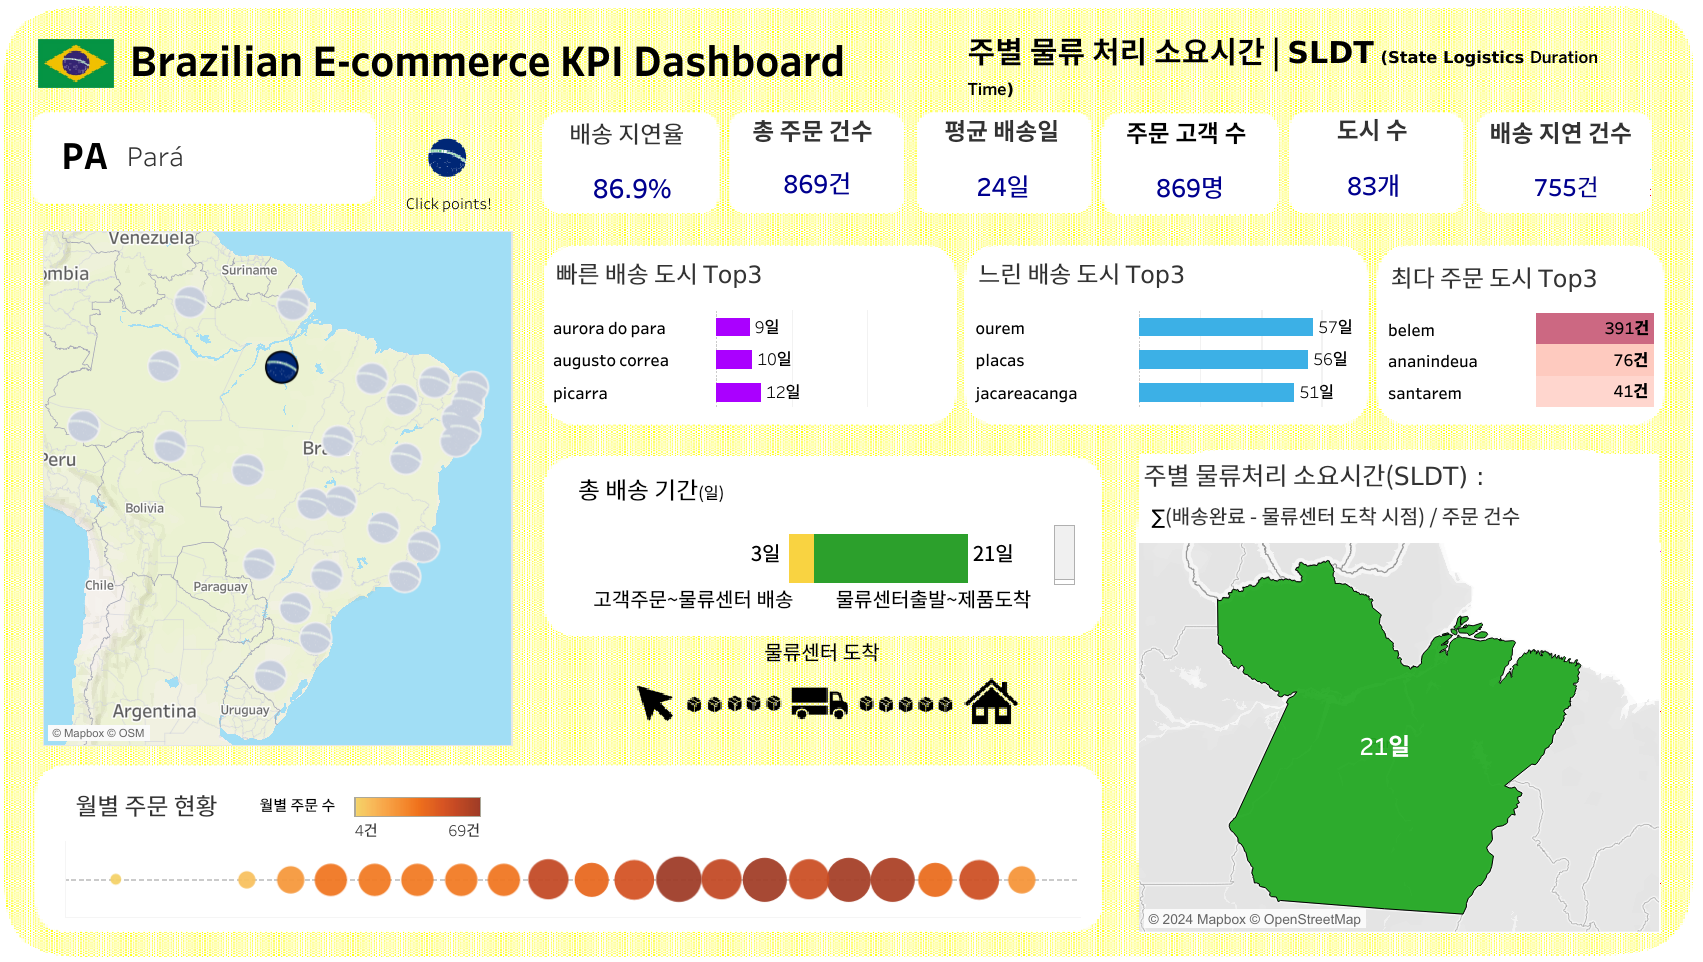

In [61]:
Image.open('overview.png')

💎 총 27개의 주(State)를 필터로 삼아 다른 항목들과 연동되도록 구성하였습니다.  
왼쪽의 브라질 지도에서 각 지역에 해당하는 포인트를 클릭하면 연동됩니다.  
  
💎 현황 분석 : 예시) State - PA
1. 배송 지연율 : 예상 도착 시간보다 실제 도착 시간이 더 늦은 경우인 "delayed"가 전체 배송 중 차지하는 비율을 말합니다. 
2. 총 주문 건수 : 각 주에서 주문이 얼마나 많은지 알아보기 위해 주문 건수를 측정한 값입니다.
3. 평균 배송일 : 제품이 고객에게 도착한 시점에서 고객이 주문을 한 시점을 뺀 값입니다. 일 단위로 표현하였습니다.
4. 주문 고객 수 : 각 주의 Customer_id를 기준으로 주문 고객이 몇 명이 되는지를 측정한 값입니다.
5. 도시 수: 각 주에 포함된 도시의 개수를 말합니다. 주문 고객의 도시 개수를 기준으로 한 것에 한정하였습니다.
6. 배송 지연 건수 : 각 주의 주문 건수 중에서 "delayed"가 된 주문 건수를 측정한 값입니다.
7. 빠른 배송 도시 : 각 주에서 평균적으로 배송이 가장 빠른 도시 TOP3를 보여줍니다. 예를 들어 AURORA DO PARA라는 도시의 경우, 9일이면 제품이 도착 완료됩니다.
8. 느린 배송 도시 : 각 주에서 평균적으로 배송이 가장 느린 도시 TOP3를 보여줍니다. 예를 들어 가장 느린 도시는 OUREM으로, 57일까지 배송이 걸렸습니다.
9. 최다 주문 도시 : 각 주에서 주문 건수가 가장 많은 도시 Top3를 보여줍니다.
10. 총 배송 기간 : (물류센터 도착 시점 - 고객 주문 시점)과 (제품 도착 시점 - 물류센터 도착 시점)을 각각 계산하여 일 기준으로 나타냈습니다. 전체 배송 기간 중에서 (제품 도착 시점 - 물류센터 도착 시점)의 비중이 매우 크다는 것을 시각적으로, 직관적으로 확인할 수 있습니다.
11. 주별 물류처리 소요 시간 : 각 주를 zoom in하여 그 지역을 관찰함과 동시에 SLDT를 보여줍니다.
12. 월별 주문 현황 : 주문량이 월별로 얼마나 많았는지를 나타냅니다.

# 4.2 솔루션 제안

🎈 이러한 현황 분석을 바탕으로 로컬 물류 센터를 설립할만한 입지를 선정합니다. 물류센터를 설립하거나 근처의 로컬 배송 업체와 협력을 강화하는 방향으로 배송 시간 단축을 실현할 수 있습니다.

🎈 먼저 브라질의 SLDT를 국가적인 시각에서 관찰합니다. 이는 SLDT의 각 주를 클릭하면 연동되는 스타일입니다.

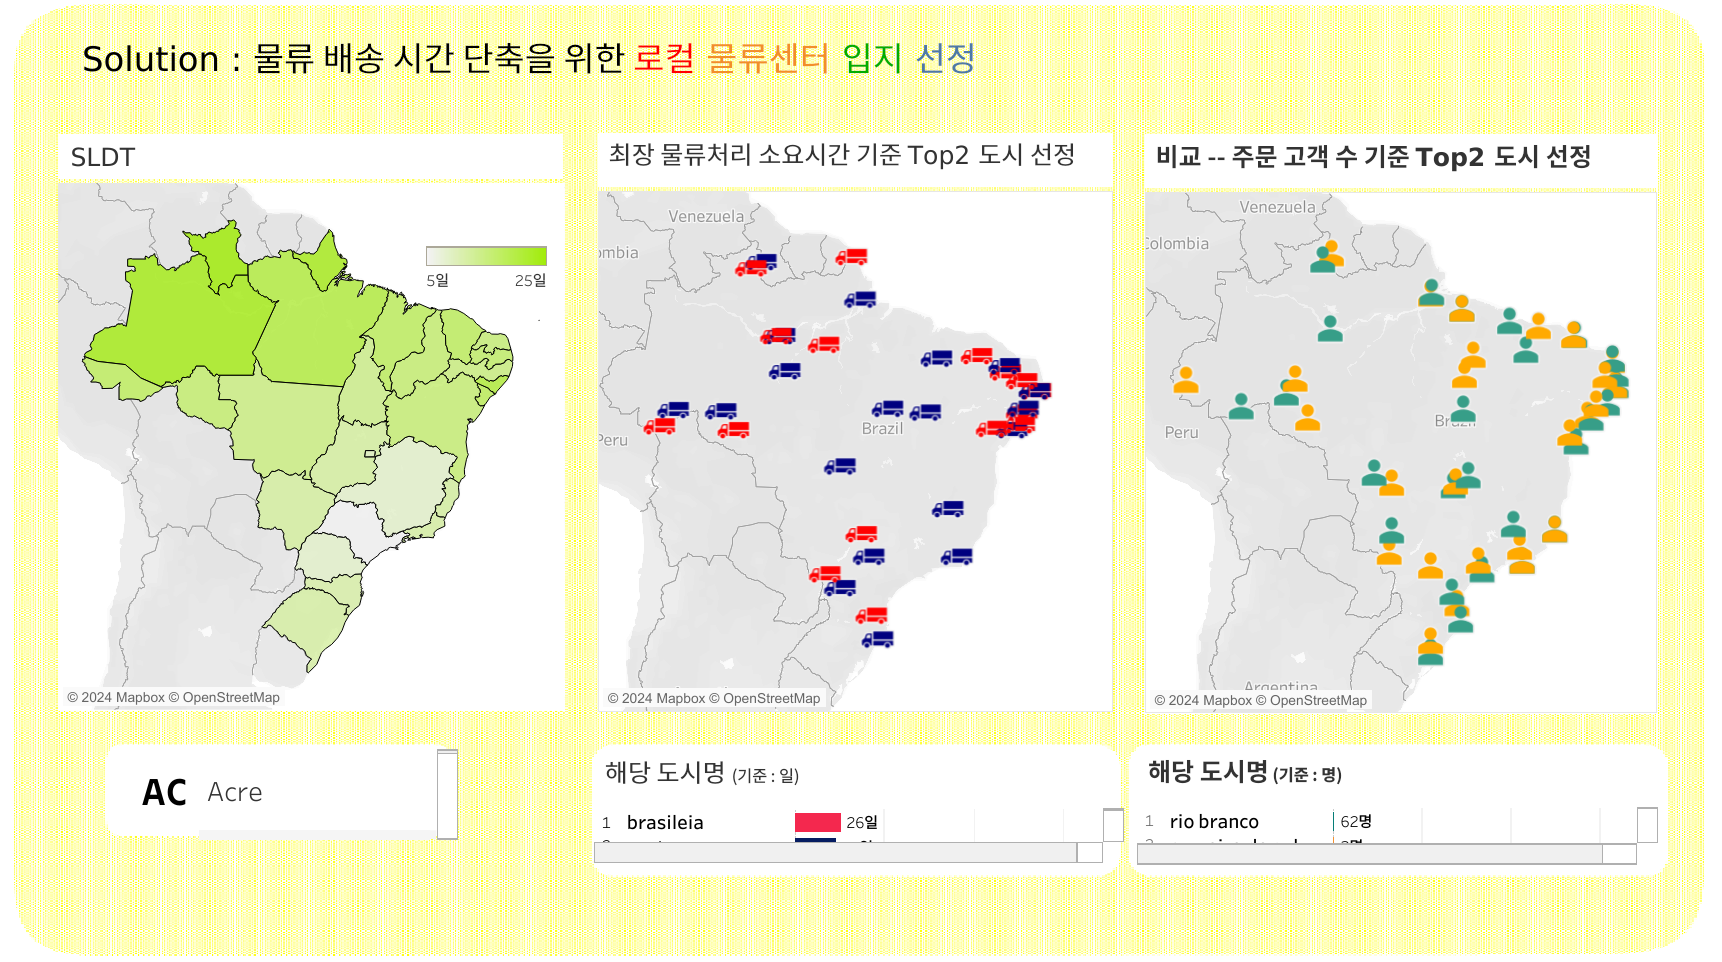

In [62]:
Image.open('solution.png')

💎 각 주별로 최소 5일에서 25일까지 SLDT가 나타난 것을 알 수 있습니다. 이에 따라 가장 배송이 취약한 주를 먼저 선정할 수 있습니다.
  
💎 각 주에 로컬 물류센터를 설립할만한 도시를 선정하였습니다. 두번째 맵은 각 주에서 가장 배송 기간이 긴 도시 TOP2로서 1순위와 2순위를 각각 빨간색과 남색으로 표시하였습니다.
  
💎 세 번째 맵은 각 주에서 주문 고객 수가 많은 도시 TOP2로서 1순위와 2순위를 각각 청록색과 주황색으로 표시하였습니다.

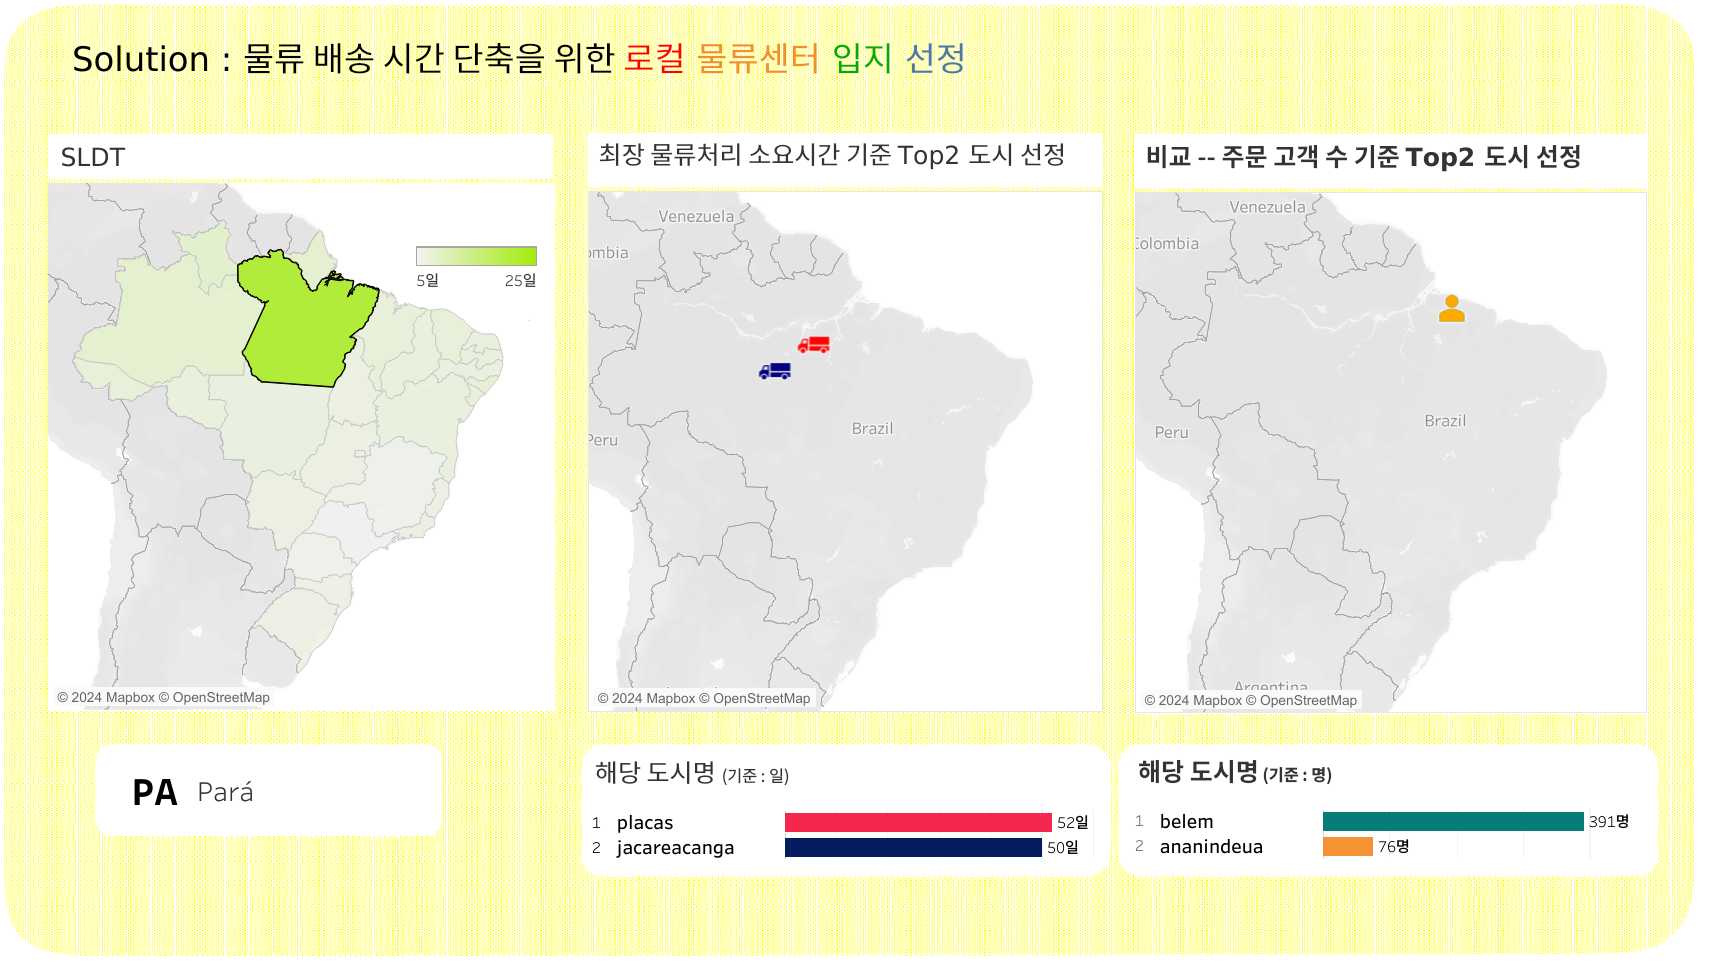

In [63]:
Image.open('solution_example.png')

💎 SLDT를 보여주는 주를 클릭하면 각각 두 번째, 세 번째 맵의 주에 TOP2 도시가 표시됩니다. 각각의 기준에 따라 최적의 도시가 다른 것을 알 수 있습니다.
  
💎 예를 들어, PA주의 경우, 물류처리 소요시간이 가장 긴 도시로 PLACAS와 JACAREACANGA가 제시됩니다. 각각 물류처리가 52일, 50일까지 걸리는 것을 알 수 있습니다. 주문 고객 수를 기준으로 할 때는 BELEM, ANANINDEUA가 제시됩니다. 각각의 도시에는 주문 고객이 391명, 76명이 거주하고 있습니다.